# GLMのモデル選択

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
sed = pd.read_csv("data/data3a.csv")

In [3]:
fit_intercept = smf.glm(formula="y~1", data=sed, family = sm.families.Poisson()).fit()
fit_f = smf.glm(formula="y~f", data=sed,  family = sm.families.Poisson()).fit()
fit_x = smf.glm(formula="y~x", data=sed,  family = sm.families.Poisson()).fit()
fit_xf = smf.glm(formula="y~x+f", data=sed,  family = sm.families.Poisson()).fit()
fit_x6 = smf.glm(formula="y ~ x + I(x**2) + I(x**3) + I(x**4) + I(x**5) + I(x**6)",
                 data=sed, family = sm.families.Poisson()).fit()

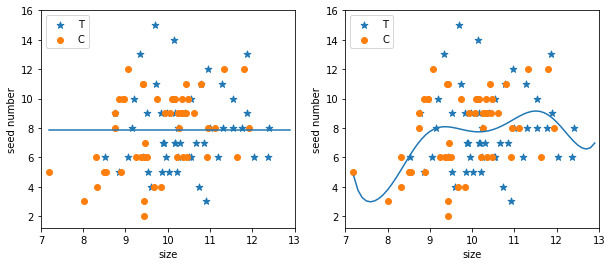

In [4]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
x = np.arange(7.2, 13, 0.1)
# パラメーター受け取る
inter = fit_intercept.params
alpha, beta1, beta2, beta3, beta4, beta5, beta6 = fit_x6.params

# 非説明変数の生成
y_intercept = float(np.exp(inter)) * np.ones(len(x))
y_x6 = np.exp(alpha + beta1*x + beta2*(x**2) + beta3*(x**3)  + beta4*(x**4)  + beta5*(x**5)+ beta6*(x**6))


# 左の図
axL.scatter(sed.x[sed.f=='T'], sed.y[sed.f=='T'], label='T', marker='*', s=50)
axL.scatter(sed.x[sed.f=='C'], sed.y[sed.f=='C'], label='C')
axL.plot(x, y_intercept)
axL.set_xlim(7, 13)
axL.set_ylim(1.2, 16)
axL.legend(loc='upper left')
axL.set_xlabel('size')
axL.set_ylabel('seed number')

# 右の図
axR.scatter(sed.x[sed.f=='T'], sed.y[sed.f=='T'], label='T', marker='*', s=50)
axR.scatter(sed.x[sed.f=='C'], sed.y[sed.f=='C'], label='C')
axR.plot(x, y_x6)
axR.set_xlim(7, 13)
axR.set_ylim(1.2, 16)
axR.legend(loc='upper left')
axR.set_xlabel('size')
axR.set_ylabel('seed number')

plt.show()

## 統計モデルの当てはまりの悪さ：逸脱度

### 様々な逸脱度($\log L^*$ は最大対数尤度)

| 名前 | 定義 | 
|:-----------|:------------|
| 逸脱度(D)       |        -2$\log L^*$ |
| 最小逸脱度     |      フルモデルを当てはめた時のD |
| 残差逸脱度       |        D-最小のD |
| 最大逸脱度         |          Nullモデルを当てはめた時のD |
|  Null逸脱度     |   最大のD-最小のD    |

In [5]:
lambda_full = stats.poisson.logpmf(sed.y, sed.y)
logLik_full = np.sum(lambda_full)
min_dev = -2*logLik_full
print("最小逸脱度 : " + str(min_dev))

最小逸脱度 : 385.779505049


In [6]:
lambda_null = float(np.exp(inter)) * np.ones(len(sed.x))
logLik_null = np.sum(stats.poisson.logpmf(sed.y, lambda_null))
max_dev = -2*logLik_null
print("最大逸脱度 : " + str(max_dev))

最大逸脱度 : 475.286442619


#### モデル選択規準AIC
AICは統計モデルの当てはまりの良さではなく、予測の良さを重視するモデルの選択規準です。<br>
AICが小さいほど良いモデルとなる


\begin{align}
AIC &= -2 {(最大対数尤度) - (最尤推定したパラメーター数)}\\
&= -2 (\log L^* - k)\\
&= D + 2k
\end{align}

In [7]:
aic_null = fit_intercept.aic
aic_f = fit_f.aic
aic_x = fit_x.aic
aic_xf = fit_xf.aic
aic_full = -2*(logLik_full - 100)

In [8]:
logLik_x = np.sum(stats.poisson.logpmf(sed.y, fit_x.predict(sed.x)))
logLik_f = np.sum(stats.poisson.logpmf(sed.y, fit_f.predict(sed.f)))
logLik_xf = np.sum(stats.poisson.logpmf(sed.y, fit_xf.predict(sed.loc[:,['x', 'f']])))

In [9]:
k = np.array([1, 2, 2, 3, 100])
logLik = np.array([logLik_null, logLik_f, logLik_x, logLik_xf, logLik_full])
deviance = -2*logLik
residual = deviance - deviance[4]
aic = np.array([aic_null, aic_f, aic_x, aic_xf, aic_full])

select = np.vstack([k, logLik, deviance, residual, aic]).T
select = pd.DataFrame(data = select, columns=['k', "logL*", "deviance", "residual deviance", "AIC"],
                      index=["null", "f", "x", "x+f", "full"])
print(select)

          k       logL*    deviance  residual deviance         AIC
null    1.0 -237.643221  475.286443          89.506938  477.286443
f       2.0 -237.627257  475.254514          89.475009  479.254514
x       2.0 -235.386251  470.772502          84.992996  474.772502
x+f     3.0 -235.293719  470.587438          84.807933  476.587438
full  100.0 -192.889753  385.779505           0.000000  585.779505
